(sec:vibrot)=
# Rovibronic states

The sum-over-states expressions for response functions are expressed in terms of the exact rovibronic eigenstates of the molecular Hamiltonian in the absence of external fields. These states are rarely available in practical calculations, where instead electronic states are employed. However, for a diatomic system, we can determine the rovibrational wave functions and the associated transition moments and energies.

Adopting the [adiabatic Born–Oppenheimer approximation](sec:BO_approximation), the total molecular rovibronic wave function takes the form of a product

$$
\Psi_{K, k}(\mathbf{r}, \mathbf{R}) = 
\Phi_{K;k}(\mathbf{R})
\Psi_K^\mathrm{e}(\mathbf{r}; \mathbf{R})
$$

where $K$ and $k$ are indices identifying the electronic and rovibrational levels, respectively. For a diatomic system, the rovibrational wave function is in turn separated into its vibrational, $\psi$, and rotational, $\psi_\mathrm{r}$, components

$$
\Phi_{K;k}(\mathbf{R}) =  \psi_k(R) \psi_{\mathrm{r}; k}(\theta,\phi) 
$$

where $k$ is understood as a compound index uniquely identifying a given rotational level of a given vibrational state.

## Rotational Schrödinger equation  

The Schrödinger equation for diatomic molecule with *fixed* bond length equals

$$
- \frac{\hbar^2}{2\mu R_0^2} \left[ 
\frac{1}{\sin\theta}\frac{\partial}{\partial \theta} \left(\sin\theta \frac{\partial}{\partial \theta} \right) 
+ 
 \frac{1}{\sin^2\theta} \frac{\partial^2}{\partial \phi^2} 
\right] \psi_\mathrm{r}(\theta,\phi)  = E \, \psi_\mathrm{r}(\theta,\phi) 
$$

or, equivalently,

$$
\frac{\hat{L}^2\psi_\mathrm{r}(\theta,\phi)}{2\mu R_0^2} = E \, \psi_\mathrm{r}(\theta,\phi)
$$

where $\hat{L}^2$ is the square of the total angular moment operator. The angles $\theta$ and $\phi$ describe the orientation of the diatomic molecule with respect to a laboratory-fixed coordinate system and $\mu$ is the reduced mass defined as

$$
\mu=\dfrac{M_A M_B}{M_A + M_B}
$$

The eigenfunctions to the total angular momentum operator are known to the the sperical harmonics, $Y_J^M(\theta, \phi)$, and the associated rotational energies are given by

$$
E_J =  \frac{\hbar^2 J(J+1)}{2\mu R_0^2} = B J(J+1)
$$

introducing the rotational constant $B$. We note that rotational levels are $(2J+1)$-fold degenerate.

Transitions between rotational levels are classified according to

1. Q-branch: when $\Delta J = 0$
2. R-branch: when $\Delta J = +1$
3. P-branch: when $\Delta J = -1$


## Numerov's method and the vibrational Schrödinger equation

[Numerov's method](https://en.wikipedia.org/wiki/Numerov%27s_method) can be employed to solve 1D differential equations using finite differences on a grid of points. It applies to a differential equation on the form

$$
\frac{d^2 y}{dx^2} = -g(x)y(x) + s(x)
$$ 

This method will be used to solve the vibrational part of the Schrödinger equation that for the lowest rotational level ($J=0$) takes the form

$$   
- \dfrac{\hbar^2}{2\mu} \dfrac{\partial^2\psi(R)}{\partial R^2} +V(R) \psi(R) = E \psi(R) 
$$

For notational convenience, we introduce $x = (R - R_0)$ to arrive at

$$ \psi^{\prime \prime} (x) = - k^{2} (x) \psi (x) $$ 

where

$$ 
k^{2} (x) = \dfrac {2\mu} {\hbar^{2}} [ E - V (x) ] 
$$

The values of the wave function in three equidistant points separated by $h$ are related as

$$ 
\psi(x_{i+1}) = 
\dfrac{
    \psi(x_{i}) 
    \left( 2 + \dfrac {10 h^{2}} {12} k^{2}(x_{i}) \right) - 
    \psi(x_{i-1}) 
    \left( 1 - \dfrac {h^{2}} {12} k^{2}(x_{i-1}) \right)
    }{
    1 - \dfrac {h^{2}} {12} k^{2}(x_{i+1})
    } 
$$

from which solutions are found by the algorithm

1. Guess the energy $E_\mathrm{guess}$

2. For $E_\mathrm{guess}$, determine the classically allowed interval [$x_a,x_b$] inside $V(x)$

3. Pick two points $x_\mathrm{min}$ and $x_\mathrm{max}$ far into the classically forbidden region and impose the wave function to be zero at these points

4. Determine iteratively the wave functions inside the interval $[x_\mathrm{min}, x_\mathrm{max}]$:
   1. If $\psi(x_a)<\epsilon$ and $\psi(x_b)<\epsilon$, accept the wave function
   2. If not, renew the energy guess

## Numerov's method in VeloxChem

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Warning * Setting MKL_THREADING_LAYER to "INTEL".


We will use HCl as an example.

In [2]:
mol_str = """
Cl   0.0     0.0   0.0
H    1.274   0.0   0.0
"""

molecule = vlx.Molecule.read_molecule_string(mol_str, units="angstrom")

basis_set_label = "6-31+G"
basis = vlx.MolecularBasis.read(molecule, basis_set_label)

scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp", "grid_level": 4}

The following settings are available for the Numerov solver in VeloxChem.

In [3]:
num_drv = vlx.NumerovDriver()
num_drv.print_keywords()

                       @numerov                                                                                           
                     --------------------------------------------------------------------------------                     
                       pec_displacements   sequence       PEC scanning range [bohr]                                       
                       pec_potential       string         potential type for fitting                                      
                       reduced_mass        float          reduced mass of the molecule                                    
                       el_transition       boolean        include an electronic transition                                
                       final_el_state      integer        final state of the electronic transition                        
                       exc_conv_thresh     float          excited state calculation threshold                             
                

We will determine the potential on an interval of 

In [4]:
numerov_settings = {
    "n_vib_states": 4,
    "pec_displacements": "-0.3 - 0.9 (0.2)",
    "el_transition": "no",
    "pec_potential": "morse",
    "n_rot_states": 10,
}
num_drv.update_settings(numerov_settings, scf_settings, method_settings)
num_results = num_drv.compute(molecule, basis)

                                                                                                                          
                                           Potential Energy Curve Driver Setup                                            
                                                                                                                          
                              Number of Geometries          : 7                                                           
                              Wave Function Model           : Spin-Unrestricted Kohn-Sham                                 
                              SCF Convergece Threshold      : 1.0e-06                                                     
                              DFT Functional                : B3LYP                                                       
                              Molecular Grid Level          : 4                                                           
                

The results are stored in a dictionary.

In [5]:
print(num_results.keys())

dict_keys(['grid', 'potential', 'psi', 'vib_levels', 'excitation_energies', 'oscillator_strengths'])


In [6]:
grid = num_results["grid"]
potential = num_results["potential"]

vib_psi2 = num_results["psi"] ** 2
vib_energies = num_results["vib_levels"]

exc = num_results["excitation_energies"]
osc = num_results["oscillator_strengths"]

The vibrational levels can be plotted against the potential energy curve.

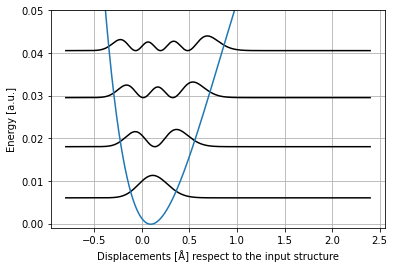

In [7]:
fig, ax1 = plt.subplots()

for energy, psi2 in zip(vib_energies, vib_psi2):
    ax1.plot(grid, energy + psi2, "k")

ax = plt.subplot()
ax.plot(grid, potential)
ax.set_ylim(-0.001, 0.05)
ax.set_xlabel("Displacements [Å] respect to the input structure")
ax.set_ylabel("Energy [a.u.]")

plt.grid(True)

plt.show()

## Rovibrational spectra

Once we have the vibrational wave functions we can calculate the dipole transition moments

$$ 
\mu^{fi} = \langle \psi_{f} | \mu(R) | \psi_{i} \rangle
$$

where $\mu(R)$ is the electronic dipole moment at internuclear separation distance $R$.

Only the first transition dipole moment (corresponding to the Q-branch) is relevant and the rest are negligible. We will obtain the fine structure by deriving the rotational excited states for the R and P branches.

Applying the rotational selection rules derived before for the rigid rotor, we get the P-branch ($\Delta J = -1$)

$$ 
E = \hbar \omega_{\text{stretch}} + \left( \dfrac{h^2}{8\pi^2I} \right)((J - 1)J - J(J + 1)) = \hbar \omega_{\text{stretch}} -2\left( \dfrac{h^2}{8\pi^2 I} \right)J 
$$

and the R-branch ($\Delta J = +1$)

$$
E = \hbar \omega_{\text{stretch}} + \left( \dfrac{h^2}{8\pi^2I} \right)((J+1)(J+2) - J(J + 1)) = \hbar \omega_{\text{stretch}} + 2\left( \dfrac{h^2}{8\pi^2I} \right)(J + 1) $$

where

$$ 
I = \frac{m_a m_b}{m_a + m_b} R^2 
$$ 

VeloxChem takes care of the spectra and the branches storing the data on the keys: `excitation_energies` and `oscillator_strengths`.

As well, computes the dipole moment for every point of the potential energy curve

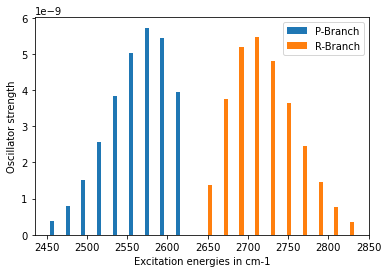

In [8]:
ax1 = plt.bar(exc["P"], osc["P"], width=5.0, label="P-Branch")
ax2 = plt.bar(exc["R"], osc["R"], width=5.0, label="R-Branch")
plt.xlabel("Excitation energies in cm-1")
plt.ylabel("Oscillator strength")
plt.legend()

plt.show()

## Vibronic transitions

In this case, we want to consider the transition dipole moments between rovibrational states in different electronic states. The expression for the transition dipole integral will in this case involve the ground, $|0\rangle$, and final, $|F\rangle$, electronic states.

Expanding the electronic transition moment in a Taylor series about the equilibrium distance of the ground electronic state, we get

$$
\mu^{F0}(R) = \mu_{F0}(R_0) +
\left.
\dfrac{\partial \mu^{F0}}{\partial R} 
\right|_{R_{0}}
(R - R_{0}) + \cdots .
$$ 

Truncating this expansion to first and second order are known as the Frank–Condon and Herzberg–Teller approximations, respectively. We will here adopt the former.

In [9]:
num_drv = vlx.NumerovDriver()

numerov_settings = {
    "n_vib_states": 3,
    "pec_displacements": "-0.3 - 0.9 (0.2)",
    "el_transition": "yes",
    "final_el_state": 2,
    "pec_potential": "morse",
}
num_drv.update_settings(numerov_settings, scf_settings, method_settings)
num_results = num_drv.compute(molecule, basis)

                                                                                                                          
                                           Potential Energy Curve Driver Setup                                            
                                                                                                                          
                              Number of Geometries          : 7                                                           
                              Wave Function Model           : Spin-Unrestricted Kohn-Sham                                 
                              SCF Convergece Threshold      : 1.0e-06                                                     
                              DFT Functional                : B3LYP                                                       
                              Molecular Grid Level          : 4                                                           
                

In [10]:
print(num_results.keys())

dict_keys(['grid', 'i_potential', 'i_psi', 'i_vib_levels', 'f_potential', 'f_psi', 'f_vib_levels', 'excitation_energies', 'oscillator_strengths'])


In [11]:
grid = num_results["grid"]

dE_elec = np.min(num_drv.pec_energies["f"]) - np.min(num_drv.pec_energies["i"])

gs_potential = num_results["i_potential"]
gs_vib_psi2 = num_results["i_psi"] ** 2
gs_vib_energies = num_results["i_vib_levels"]

es_potential = num_results["f_potential"]
es_vib_psi2 = num_results["f_psi"] ** 2
es_vib_energies = num_results["f_vib_levels"]

exc = num_results["excitation_energies"]
osc = num_results["oscillator_strengths"]

In [12]:
displacements = num_drv.pec_displacements
gs_energies = num_drv.pec_energies["i"]
es_energies = num_drv.pec_energies["f"]

delta_E = np.min(es_energies) - np.min(gs_energies)

The vibrational levels can be then plotted against the potential energy curves:

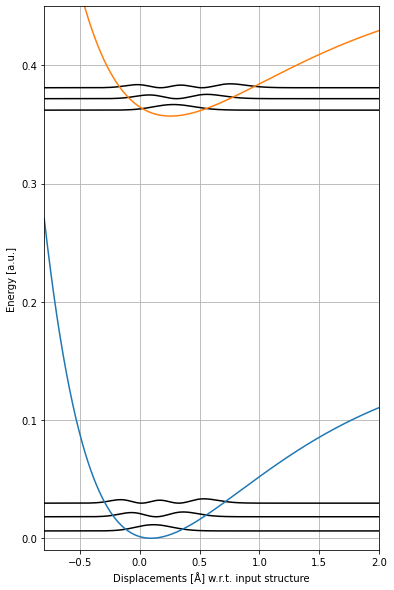

In [16]:
fig, ax1 = plt.subplots(figsize=(6, 10))

for energy, psi2 in zip(gs_vib_energies, gs_vib_psi2):
    ax1.plot(grid, energy + psi2, "k")

for energy, psi2 in zip(es_vib_energies, es_vib_psi2):
    ax1.plot(grid, delta_E + energy + psi2, "k")

ax = plt.subplot()
ax.plot(grid, gs_potential)
ax.plot(grid, es_potential + delta_E)
ax.set_xlim(-0.8, 2.0)
ax.set_ylim(-0.01, 0.45)
ax.grid(True)
ax.set_xlabel("Displacements [Å] w.r.t. input structure")
ax.set_ylabel("Energy [a.u.]")

plt.show()

Now we can just plot the spectrum by representing the results from the driver:

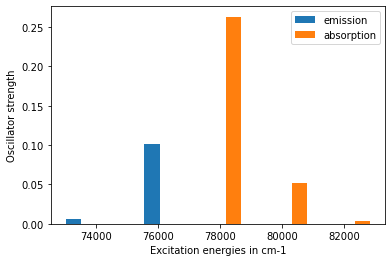

In [17]:
plt.bar(exc["emission"], osc["emission"], width=500.0, label="emission")
plt.bar(exc["absorption"], osc["absorption"], width=500.0, label="absorption")

plt.legend()
plt.xlabel("Excitation energies in cm-1")
plt.ylabel("Oscillator strength")

plt.show()

## User defined potential

As an alternative to the automatized determination of potential energy curves and transition moments, these may be instead be determined separately, perhaps with a highly accurate post-Hartree–Fock approach. The method `read_pec_data` is then used. 

As a simple illustration, we will use two harmonic potentials and transition moment that is independent of nuclear displacements.

In [18]:
num_drv = vlx.NumerovDriver()

In [19]:
x = np.arange(-0.7, 2.01, 0.1)

delta_E = 0.2

bond_lengths = x + 2.0
gs_energies = 0.75 * x**2
es_energies = 0.5 * (x - 0.35) ** 2 + delta_E

tmom = [0, 0, 1.0]
trans_moments = [tmom for displacement in x]

In [22]:
num_drv.read_pec_data(bond_lengths, trans_moments, gs_energies, es_energies)

num_drv.set_reduced_mass(1.0)

numerov_settings = {
    "n_vib_states": 10,
    "el_transition": "yes",
    "final_el_state": 1,
    "pec_potential": "harmonic",
}
num_drv.update_settings(numerov_settings, scf_settings, method_settings)

In [23]:
num_results = num_drv.compute()

                                                                                                                          
                                                   Numerov Driver Setup                                                   
                                                                                                                          
                                         Number of Vibrational States : 10                                                
                                         Energy Convergence Threshold : 1.0e-12                                           
                                         Max. Number of Iterations    : 1000                                              
                                         Grid Points per Bohr Radius  : 500                                               
                                         Margin right of scanned PEC  : 1.50                                              
                

Retrieving results from the calculation.

In [24]:
grid = num_results["grid"]

gs_potential = num_results["i_potential"]
gs_psi2 = num_results["i_psi"] ** 2
gs_vib_energies = num_results["i_vib_levels"]

es_potential = num_results["f_potential"]
es_psi2 = num_results["f_psi"] ** 2
es_vib_energies = num_results["f_vib_levels"]

exc = num_results["excitation_energies"]
osc = num_results["oscillator_strengths"]

Plotting potentials and vibrational wave functions.

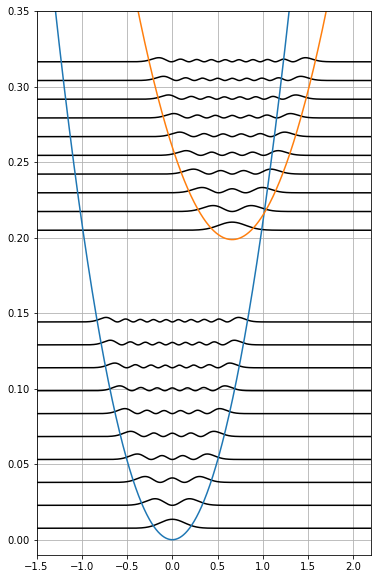

In [26]:
fig, ax1 = plt.subplots(figsize=(6, 10))

for energy, psi2 in zip(gs_vib_energies, gs_psi2):
    ax1.plot(grid, energy + psi2, "k")

for energy, psi2 in zip(es_vib_energies, es_psi2):
    ax1.plot(grid, delta_E + energy + psi2, "k")

ax = plt.subplot()

ax.plot(grid, gs_potential)
ax.plot(grid, es_potential + delta_E)

ax.set_xlim(-1.5, 2.2)
ax.set_ylim(-0.01, 0.35)

ax.grid(True)

plt.show()

Plotting the vibronic absorption and emission spectra.

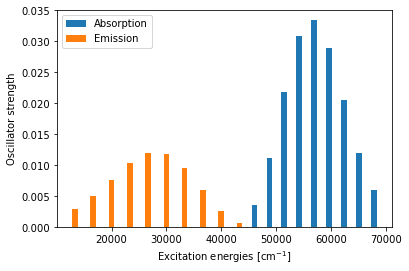

In [27]:
plt.bar(exc["absorption"], osc["absorption"], width=1000.0, label="Absorption")
plt.bar(exc["emission"], osc["emission"], width=1000.0, label="Emission")

plt.legend()
plt.xlabel(r"Excitation energies [cm$^{-1}$]")
plt.ylabel("Oscillator strength")

plt.show()